<a href="https://colab.research.google.com/github/pdrobny/Potential_Talents/blob/main/P3_part2_rev0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install scipy seaborn
!pip install torch torchvision torchaudio
!pip install tensorflow
!pip install torchview

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import random
import requests
import sys
import regex as re
import plotly.express as px
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, make_scorer, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text
from sklearn.feature_selection import RFE
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore', category=UserWarning)
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchview import draw_graph
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder


print(torch.__version__)
tf.__version__


2.6.0+cu124


'2.18.0'

In [3]:
df = pd.read_csv('talents.csv')
df

,id,title,sentence_bert_cossim
0,1,innovative and driven professional seeking a r...,1.000000
1,431,aspiring data science professional focused on ...,0.769162
2,544,data analyst data scientist business analyst d...,0.768222
3,833,data analyst turning complex data into actiona...,0.745245
4,199,ms in information systems northeastern univers...,0.727268
...,...,...,...
1260,648,research specialist university of rochester di...,0.079923
1261,730,medical biller at brick pediatric group,0.072848
1262,990,ingeniero elctrico,0.067254
1263,296,company owner at armstrong cleans carpets,0.056890


In [4]:
df['score'] = (df['sentence_bert_cossim'] * 100).astype(int)
df

,id,title,sentence_bert_cossim,score
0,1,innovative and driven professional seeking a r...,1.000000,100
1,431,aspiring data science professional focused on ...,0.769162,76
2,544,data analyst data scientist business analyst d...,0.768222,76
3,833,data analyst turning complex data into actiona...,0.745245,74
4,199,ms in information systems northeastern univers...,0.727268,72
...,...,...,...,...
1260,648,research specialist university of rochester di...,0.079923,7
1261,730,medical biller at brick pediatric group,0.072848,7
1262,990,ingeniero elctrico,0.067254,6
1263,296,company owner at armstrong cleans carpets,0.056890,5


In [5]:
df_score = df[['id','title','score']]
df_score

,id,title,score
0,1,innovative and driven professional seeking a r...,100
1,431,aspiring data science professional focused on ...,76
2,544,data analyst data scientist business analyst d...,76
3,833,data analyst turning complex data into actiona...,74
4,199,ms in information systems northeastern univers...,72
...,...,...,...
1260,648,research specialist university of rochester di...,7
1261,730,medical biller at brick pediatric group,7
1262,990,ingeniero elctrico,6
1263,296,company owner at armstrong cleans carpets,5


In [6]:
# Sort the DataFrame by score in descending order
df_score = df_score.sort_values('score', ascending=False)

# Replace the top 5 scores with 100
df_score.loc[df_score.index[:5], 'score'] = 100

# If you want to reset the index after modifying
df_score = df_score.reset_index(drop=True)

df_score


,id,title,score
0,1,innovative and driven professional seeking a r...,100
1,431,aspiring data science professional focused on ...,100
2,544,data analyst data scientist business analyst d...,100
3,833,data analyst turning complex data into actiona...,100
4,199,ms in information systems northeastern univers...,100
...,...,...,...
1260,648,research specialist university of rochester di...,7
1261,730,medical biller at brick pediatric group,7
1262,990,ingeniero elctrico,6
1263,296,company owner at armstrong cleans carpets,5


In [33]:
# prompt: create a learn to rank model with ranknet and pytorch based on df['score']

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming df_score is already defined as in the previous code

# Prepare the data
X = df_score[['title']].values  # Use only numerical features for now
y = df_score['score'].values

# 1. Encode the 'title' column using LabelEncoder
encoder = LabelEncoder()
X = encoder.fit_transform(X.ravel()) # Fit and transform the title column
X = X.reshape(-1, 1) # Reshape to 2D array

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)  # Now X contains numerical data
y = torch.tensor(y, dtype=torch.float32)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the RankNet model
class RankNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RankNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X.shape[1]  # Number of features
hidden_dim = 64  # Adjust as needed
model = RankNet(input_dim, hidden_dim)
criterion = nn.MSELoss()  # Mean Squared Error Loss; consider alternatives like Pairwise Ranking Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss = []
# Training loop
num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Example usage after training (to get predictions)

# Example data point
# Assuming 'example_features' is a numerical representation of your input
example_features = torch.tensor([[5]], dtype=torch.float32)  # Modify with actual features, ensure numerical

# Make prediction
with torch.no_grad():
    predicted_score = model(example_features)
print("Predicted score:", predicted_score.item())

Epoch [1/10], Loss: 484.6689
Epoch [2/10], Loss: 576.5013
Epoch [3/10], Loss: 626.9147
Epoch [4/10], Loss: 945.6826
Epoch [5/10], Loss: 799.2906
Epoch [6/10], Loss: 858.6785
Epoch [7/10], Loss: 475.5713
Epoch [8/10], Loss: 1011.0767
Epoch [9/10], Loss: 784.7354
Epoch [10/10], Loss: 718.5535
Predicted score: 1.775444507598877


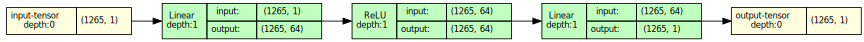

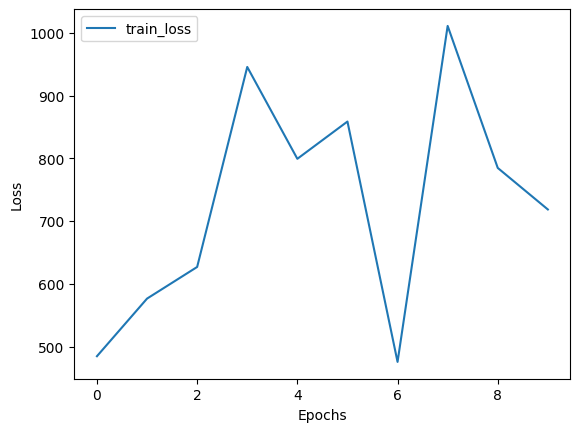

In [34]:
## Plot Loss
plt.plot(train_loss, label='train_loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show

## Plot model architecutre
model_graph = draw_graph(model, input_data = [X], graph_dir = "LR", save_graph = True, graph_name="RankNet")
model_graph.visual_graph